# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 2: Clasificación de Dígitos Manuscritos con Redes Neuronales**

### Estudiante: Hernán Zamorano Ibáñez

El objetivo de esta tarea es utilizar redes neuronales en un problema de clasificación de dígitos. Se utilizará el conjunto de datos Optical Recognition of Handwritten Digits Data Set. Este conjunto tiene 64 características, con 10 clases y 5620 muestras en total. La base de datos estará disponible en U-Campus.

Las redes a ser entrenadas tienen la siguiente estructura: capa de entrada de dimensionalidad 64 (correspondiente a los datos de entrada), capas ocultas (una o dos) y capa de salida con 10 neuronas y función de activación softmax. La función de loss (pérdida) es entropía cruzada. El optimizador que se
debe usar es Adam. La función softmax está implícita al usar la función de pérdida CrossEntropyLoss de PyTorch (**no se debe agregar softmax a la salida de la red**).

Se usará PyTorch para entrenar y validar la red neuronal que implementa el clasificador de dígitos. Se analizará los efectos de cambiar el tamaño de la red (número de capas ocultas y de neuronas en estas
capas) y la función de activación.

El siguiente código base debe ser usado para realizar las actividades pedidas.

## Observación: Antes de ejecutar su código, active el uso de GPU en Google Colab para acelerar el proceso de entrenamiento.

### Para esto: vaya a "Entorno de Ejecución" en el menú superior, haga click en "Cambiar tipo de entorno de ejecución", y seleccionar/verificar "GPU" en "Acelerador de Hardware"

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Subir datasets de dígitos (train)

In [2]:
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt

--2023-10-28 01:05:29--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640604 (626K) [text/plain]
Saving to: ‘1_digits_train.txt’

1_digits_train.txt  100%[===================>] 625.59K  --.-KB/s    in 0.05s   

2023-10-28 01:05:30 (11.4 MB/s) - ‘1_digits_train.txt’ saved [640604/640604]

--2023-10-28 01:05:30--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200

In [3]:
#from google.colab import files
#uploaded = files.upload()  # 1_digits_train.txt
#!ls

In [4]:
#from google.colab import files
#uploaded = files.upload()  # 1_digits_test.txt
#!ls

## Leer dataset de dígitos

In [5]:
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

In [6]:
df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
df_train_val

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,0,0,9,11,0,0,0,0,0,7,...,0,0,0,8,12,12,15,10,0,2
4343,0,0,6,15,2,0,0,0,0,0,...,0,0,0,7,16,16,10,1,0,6
4344,0,0,15,16,16,14,0,0,0,0,...,0,0,0,14,11,0,0,0,0,7
4345,0,0,0,1,15,11,0,0,0,0,...,0,0,0,0,1,16,10,0,0,4


In [7]:
df_test = pd.read_csv('1_digits_test.txt', names = column_names)
df_test

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,13,12,10,12,8,0,0,2,...,0,0,0,10,16,16,8,0,0,5
1,0,0,8,16,14,4,0,0,0,5,...,0,0,0,10,16,14,12,2,0,9
2,0,0,0,7,16,0,0,0,0,0,...,0,0,0,0,9,15,1,0,0,4
3,0,0,2,14,9,2,0,0,0,0,...,0,0,0,2,14,14,2,0,0,0
4,0,1,16,16,15,3,0,0,0,0,...,0,0,0,16,6,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,0,0,5,13,11,2,0,0,0,2,...,0,0,0,8,13,15,10,1,0,9
1268,0,0,0,1,12,1,0,0,0,0,...,0,0,0,0,4,9,0,0,0,4
1269,0,0,3,15,0,0,0,0,0,0,...,0,0,0,4,14,16,9,0,0,6
1270,0,0,6,16,2,0,0,0,0,0,...,0,0,0,5,16,16,16,5,0,6


In [8]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)

In [9]:
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])

<ipython-input-9-9f48500b620a>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
<ipython-input-9-9f48500b620a>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
<ipython-input-9-9f48500b620a>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns

In [10]:
df_train

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
4026,0.0,-0.338570,0.797238,0.535297,-0.599203,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,-0.302452,0.078492,-0.427291,0.468026,1.548367,0.696964,-0.186744,9
1548,0.0,-0.338570,-0.269346,0.999221,0.985819,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.121990,0.248408,0.876852,1.378118,-0.527715,-0.186744,3
1709,0.0,-0.338570,-0.482663,0.535297,0.759387,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.723436,-0.427291,0.876852,1.548367,-0.037843,-0.186744,1
2195,0.0,2.026364,1.863823,-0.392551,-2.410657,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,1.890776,1.481867,-0.652523,-0.758451,0.356618,1.186836,-0.186744,2
1216,0.0,2.026364,0.797238,0.767259,0.985819,1.661897,0.191388,-0.13043,-0.045374,2.953365,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.672439,0.356618,-0.282779,-0.186744,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,0.0,-0.338570,-1.122613,-2.248248,-0.599203,1.839863,0.493359,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-1.124400,-2.679617,0.468026,-0.664881,-0.527715,-0.186744,9
1180,0.0,0.843897,0.583922,-0.392551,0.532956,0.772065,-0.412556,-0.13043,-0.045374,3.278195,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.468026,0.867368,0.452028,-0.186744,3
3441,0.0,-0.338570,-0.269346,-0.160589,0.985819,0.950031,-0.110584,-0.13043,-0.045374,0.354728,...,-0.206188,0.0,-0.302452,0.078492,0.473640,-2.393755,-1.175631,-0.527715,-0.186744,9
1344,0.0,-0.338570,1.223872,0.999221,0.985819,0.238166,-0.412556,-0.13043,-0.045374,0.029899,...,0.911859,0.0,-0.302452,0.880421,0.924106,0.876852,1.548367,3.391260,6.008192,2


## Crear modelo

In [11]:
model = nn.Sequential(
          nn.Linear(64, 10),
          nn.ReLU(),
          nn.Linear(10,10)
        )

In [12]:
device = torch.device('cuda')

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Crear datasets y dataloaders para pytorch (train)

In [13]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

In [14]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

## Entrenamiento

In [15]:
start = time.time()

# loop over the dataset multiple times
for epoch in range(250):
  model.train()
  # Train on the current epoch
  for i, data in enumerate(dataloader_train, 0):
    # Process the current batch
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward() # backpropagation
    optimizer.step()

    # Por completar: calcule la pérdida de validación y acurracy en el batch actual

  model.eval()
  with torch.no_grad():
    # Por completar: calcule la pérdida de validación y acurracy en la época actual
    pass

  # Por hacer: imprima la pérdida de entrenamiento/validación y acurracy en la época actual
  print('epoch %d' % (epoch))

end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
epoch 101
epoch 102
epoch 103
epoch 104
epoch 105
epoch 106
epoch 107
epoch 108
epoch 109
epoch 110


In [16]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.values
        self.features = torch.FloatTensor(self.data[:, :-1])
        self.labels = torch.LongTensor(self.data[:, -1])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label


Entrenando modelo para el caso (1): 10 neuronas de capa oculta, usando función de activación ReLU y 1000 épocas como máximo


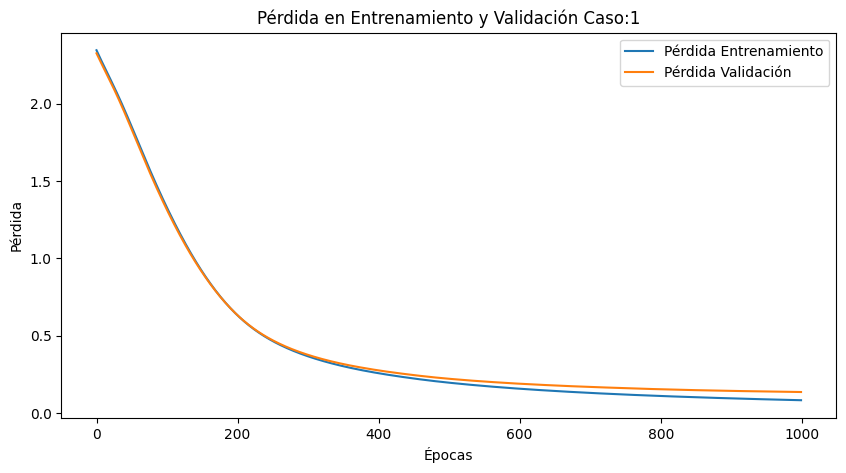

<Figure size 3000x3000 with 0 Axes>

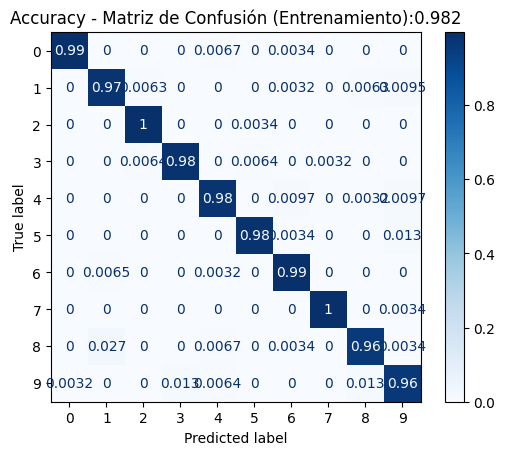

<Figure size 1500x1000 with 0 Axes>

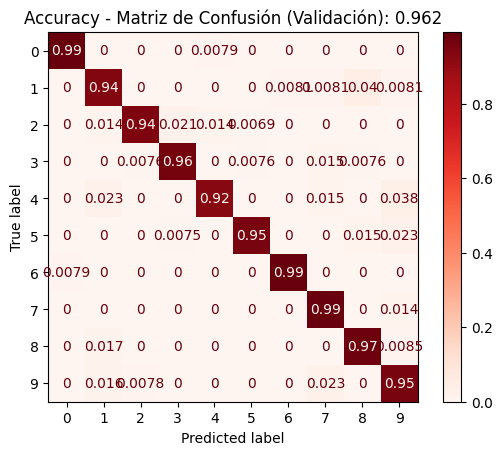

Entrenando modelo para el caso (2): 40 neuronas de capa oculta, usando función de activación ReLU y 1000 épocas como máximo


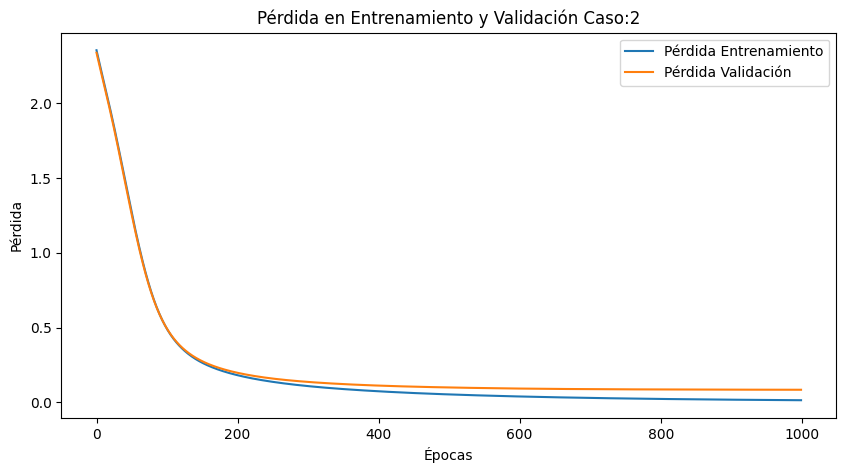

<Figure size 3000x3000 with 0 Axes>

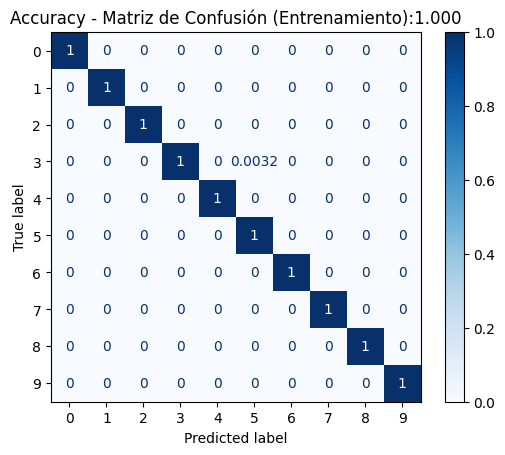

<Figure size 1500x1000 with 0 Axes>

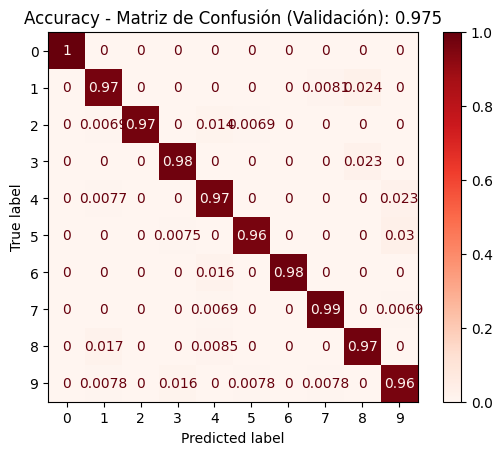

Entrenando modelo para el caso (3): 10 neuronas de capa oculta, usando función de activación Tanh y 1000 épocas como máximo


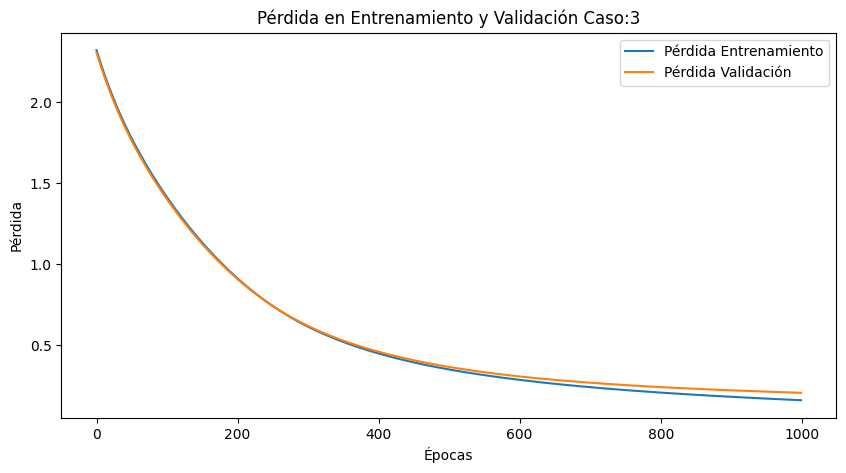

<Figure size 3000x3000 with 0 Axes>

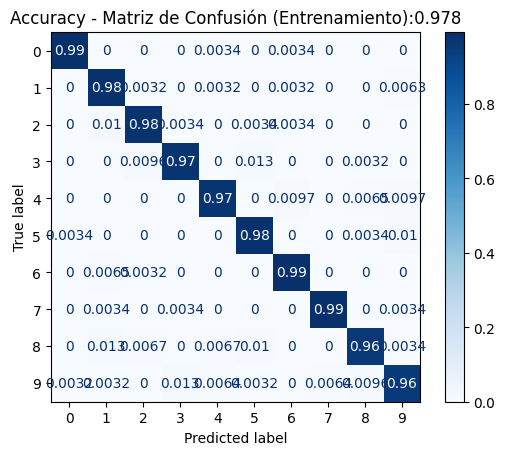

<Figure size 1500x1000 with 0 Axes>

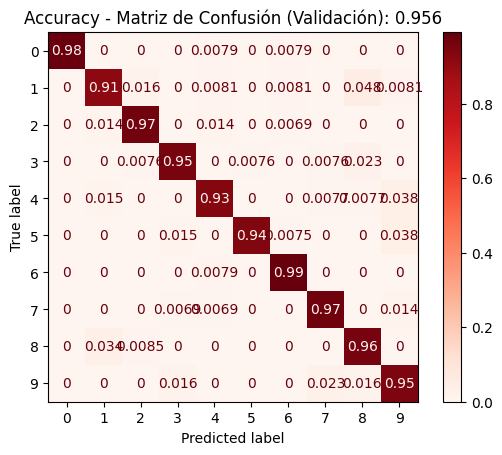

Entrenando modelo para el caso (4): 40 neuronas de capa oculta, usando función de activación Tanh y 1000 épocas como máximo


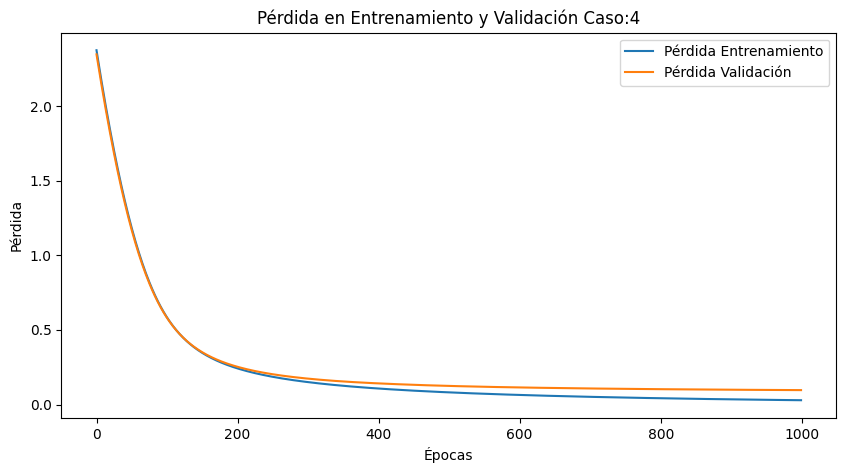

<Figure size 3000x3000 with 0 Axes>

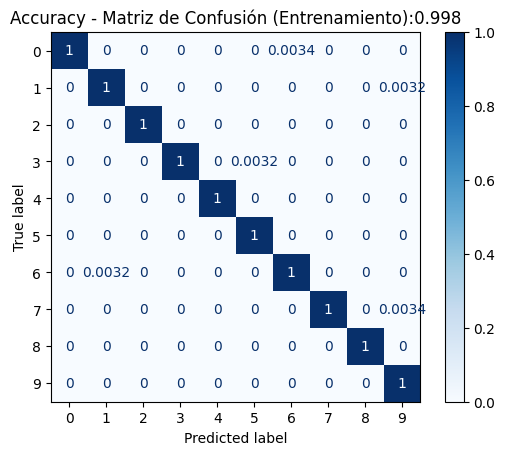

<Figure size 1500x1000 with 0 Axes>

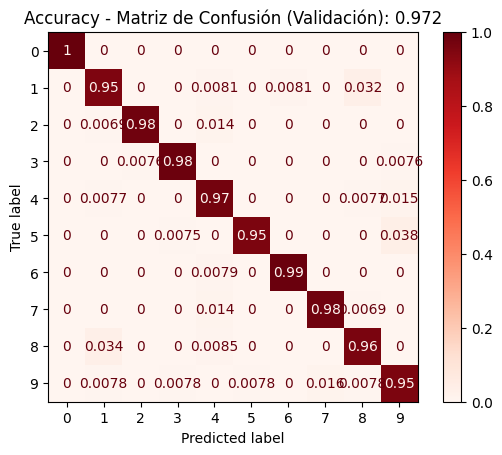

Entrenando modelo para el caso (5): 10 neuronas de capa oculta, usando función de activación ReLU y 1000 épocas como máximo


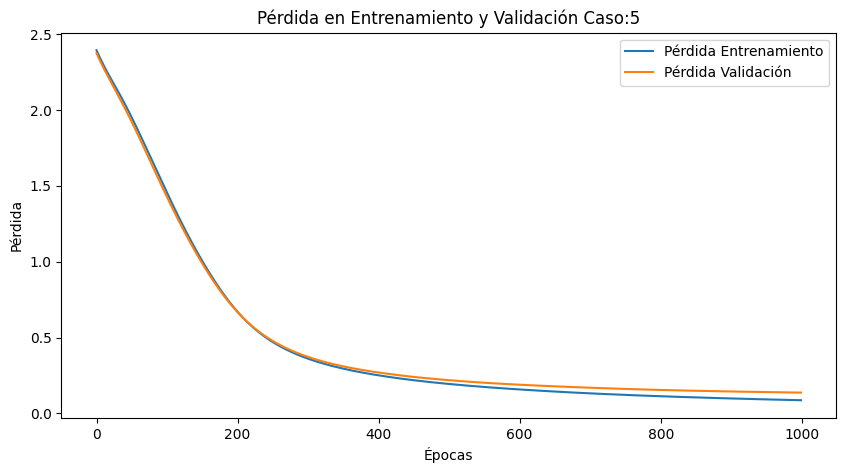

<Figure size 3000x3000 with 0 Axes>

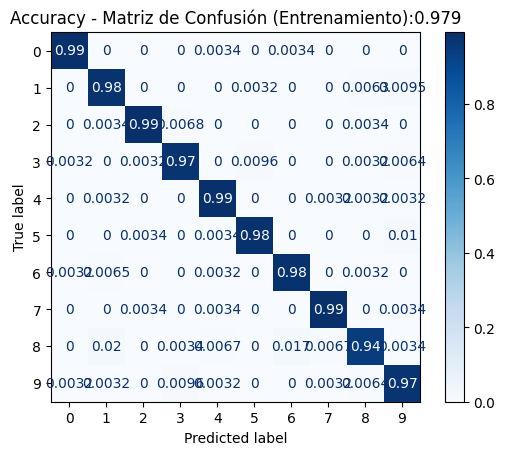

<Figure size 1500x1000 with 0 Axes>

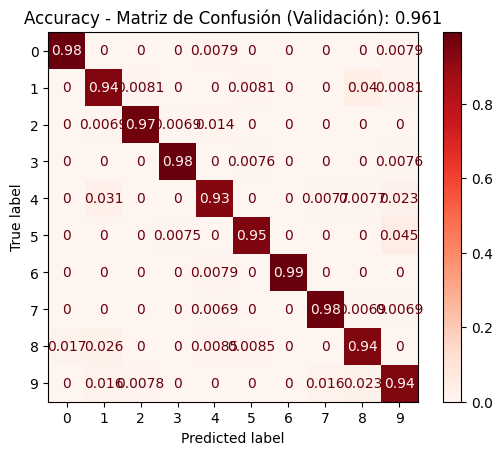

Entrenando modelo para el caso (6): 40 neuronas de capa oculta, usando función de activación ReLU y 1000 épocas como máximo


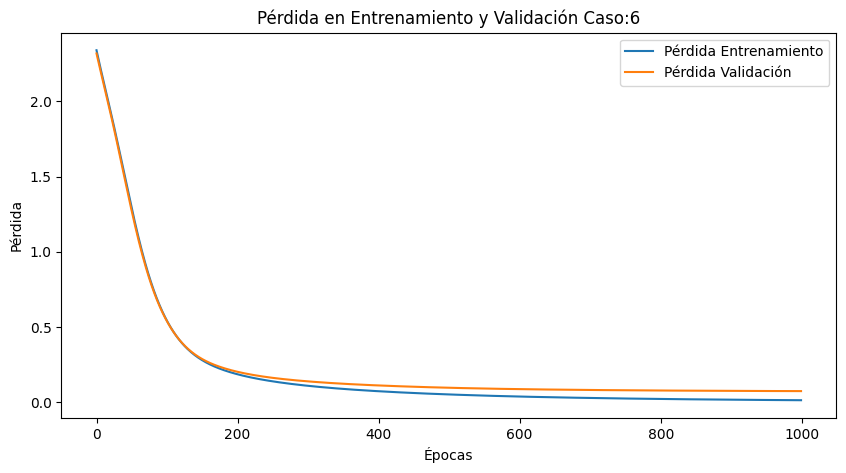

<Figure size 3000x3000 with 0 Axes>

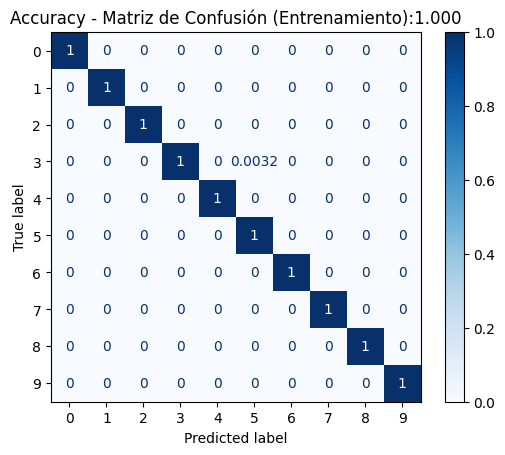

<Figure size 1500x1000 with 0 Axes>

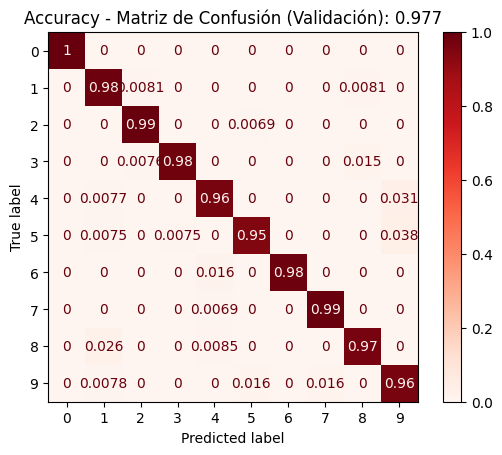

In [17]:
# Convertir DataFrames a tensores de PyTorch
X_train = torch.Tensor(df_train.iloc[:, 0:64].values)
y_train = torch.Tensor(df_train["class"].values).type(torch.LongTensor)
X_val = torch.Tensor(df_val.iloc[:, 0:64].values)
y_val = torch.Tensor(df_val["class"].values).type(torch.LongTensor)

# Función para entrenar una red neuronal
def train_neural_network(X_train, y_train, X_val, y_val, num_hidden_units, activation_fn, max_epochs):
    # Definir el modelo de la red neuronal
    model = nn.Sequential(
        nn.Linear(64, num_hidden_units),
        activation_fn,
        nn.Linear(num_hidden_units, 10),
        nn.LogSoftmax(dim=1)
    )

    # Función de pérdida y optimizador
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters())

    train_losses = []
    val_losses = []
    epochs = []
    best_val_loss = np.inf

    for epoch in range(max_epochs):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        # Calcular la pérdida en el conjunto de validación
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val)
            val_losses.append(val_loss.item())
            train_losses.append(loss.item())
            epochs.append(epoch)

            # Detener el entrenamiento si la pérdida en validación comienza a aumentar
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f'model_{num_hidden_units}_{activation_fn.__class__.__name__}.pt')
            else:
                break

    # Cargar el modelo con la mejor pérdida en validación
    model.load_state_dict(torch.load(f'model_{num_hidden_units}_{activation_fn.__class__.__name__}.pt'))
    return model, train_losses, val_losses, epochs

# Entrenar y evaluar modelos para los casos especificados
cases = [
    #(a) 10 neuronas en la capa oculta, usando función de activación ReLU y 1000 épocas como máximo
    {"num_hidden_units": 10, "activation_fn": nn.ReLU(), "max_epochs": 1000},
    #(b) 40 neuronas en la capa oculta y función de activación ReLU, y 1000 épocas como máximo
    {"num_hidden_units": 40, "activation_fn": nn.ReLU(), "max_epochs": 1000},
    #(c) 10 neuronas en la capa oculta y función de activación Tanh, y 1000 épocas como máximo
    {"num_hidden_units": 10, "activation_fn": nn.Tanh(), "max_epochs": 1000},
    #(d) 40 neuronas en la capa oculta y función de activación Tanh, y 1000 épocas como máximo
    {"num_hidden_units": 40, "activation_fn": nn.Tanh(), "max_epochs": 1000},
    #(e) 2 capas ocultas con 10 y 10 neuronas cada una y función de activación ReLU, y 1000 épocas como máximo
    {"num_hidden_units": 10, "activation_fn": nn.ReLU(), "max_epochs": 1000},
    #(f) 2 capas ocultas con 40 y 40 neuronas cada una y función de activación ReLU, y 1000 épocas como máximo
    {"num_hidden_units": 40, "activation_fn": nn.ReLU(), "max_epochs": 1000}
]

for i, case in enumerate(cases):
    print(f"Entrenando modelo para el caso ({i+1}): {case['num_hidden_units']} neuronas de capa oculta, usando función de activación {case['activation_fn'].__class__.__name__} y 1000 épocas como máximo")
#    print(f"Entrenando modelo para el caso ({i+1}): {case['num_hidden_units']} neuronas, {case['activation_fn'].__class__.__name__} activation")

    model, train_losses, val_losses, epochs = train_neural_network(X_train, y_train, X_val, y_val, case["num_hidden_units"], case["activation_fn"], case["max_epochs"])

    # Gráficos de pérdida
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Pérdida Entrenamiento')
    plt.plot(epochs, val_losses, label='Pérdida Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.title(f"Pérdida en Entrenamiento y Validación Caso:{i+1}")
    plt.show()

    # Matriz de confusión y precisión en el conjunto de entrenamiento
    y_pred_train = model(X_train).argmax(dim=1).numpy()
    cm_train = confusion_matrix(y_train.numpy(), y_pred_train, normalize='true')
    accuracy_train = accuracy_score(y_train.numpy(), y_pred_train)

    # Matriz de confusión y precisión en el conjunto de validación
    y_pred_val = model(X_val).argmax(dim=1).numpy()
    cm_val = confusion_matrix(y_val.numpy(), y_pred_val, normalize='true')
    accuracy_val = accuracy_score(y_val.numpy(), y_pred_val)

    # Gráfico de la matriz de confusión en el conjunto de entrenamiento
    plt.figure(figsize=(30, 30))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=np.arange(10))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Accuracy - Matriz de Confusión (Entrenamiento):{accuracy_train:.3f}")
    plt.show()

    # Gráfico de la matriz de confusión en el conjunto de validación
    plt.figure(figsize=(15, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=np.arange(10))
    disp.plot(cmap=plt.cm.Reds)
    plt.title(f"Accuracy - Matriz de Confusión (Validación): {accuracy_val:.3f}")
    plt.show()

#Re-enternamiento modelo para el caso (2): 40 neuronas de capa oculta, usando función de activación ReLU y 1000 épocas como máximo

Entrenando modelo para el caso (1): 40 neuronas de capa oculta, usando función de activación ReLU y 1000 épocas como máximo


<Figure size 1500x1000 with 0 Axes>

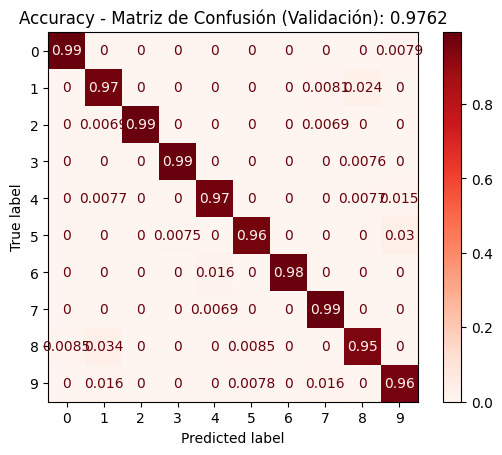

In [18]:

def train_neural_network(X_train, y_train, X_val, y_val, num_hidden_units, activation_fn, max_epochs):
    # Definir el modelo de la red neuronal
    model = nn.Sequential(
        nn.Linear(64, num_hidden_units),
        activation_fn,
        nn.Linear(num_hidden_units, 10),
        nn.LogSoftmax(dim=1)
    )

    # Función de pérdida y optimizador
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters())

    train_losses = []
    val_losses = []
    epochs = []
    best_val_loss = np.inf

    for epoch in range(max_epochs):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        # Calcular la pérdida en el conjunto de validación
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val)
            val_losses.append(val_loss.item())
            train_losses.append(loss.item())
            epochs.append(epoch)

            # Detener el entrenamiento si la pérdida en validación comienza a aumentar
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f'model_{num_hidden_units}_{activation_fn.__class__.__name__}.pt')
            else:
                break

    # Cargar el modelo con la mejor pérdida en validación
    model.load_state_dict(torch.load(f'model_{num_hidden_units}_{activation_fn.__class__.__name__}.pt'))
    return model, train_losses, val_losses, epochs
cases = [

    #(b) 40 neuronas en la capa oculta y función de activación ReLU, y 1000 épocas como máximo
    {"num_hidden_units": 40, "activation_fn": nn.ReLU(), "max_epochs": 1000},
]
for i, case in enumerate(cases):
    print(f"Entrenando modelo para el caso ({i+1}): {case['num_hidden_units']} neuronas de capa oculta, usando función de activación {case['activation_fn'].__class__.__name__} y 1000 épocas como máximo")
#    print(f"Entrenando modelo para el caso ({i+1}): {case['num_hidden_units']} neuronas, {case['activation_fn'].__class__.__name__} activation")

    model, train_losses, val_losses, epochs = train_neural_network(X_train, y_train, X_val, y_val, case["num_hidden_units"], case["activation_fn"], case["max_epochs"])

    # Matriz de confusión y precisión en el conjunto de validación
    y_pred_val = model(X_val).argmax(dim=1).numpy()
    cm_val = confusion_matrix(y_val.numpy(), y_pred_val, normalize='true')
    accuracy_val = accuracy_score(y_val.numpy(), y_pred_val)

    # Gráfico de la matriz de confusión en el conjunto de validación
    plt.figure(figsize=(15, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=np.arange(10))
    disp.plot(cmap=plt.cm.Reds)
    plt.title(f"Accuracy - Matriz de Confusión (Validación): {accuracy_val:.4f}")
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Entrenando modelo para el caso (1): 40 neuronas de capa oculta, usando función de activación ReLU y 1000 épocas como máximo


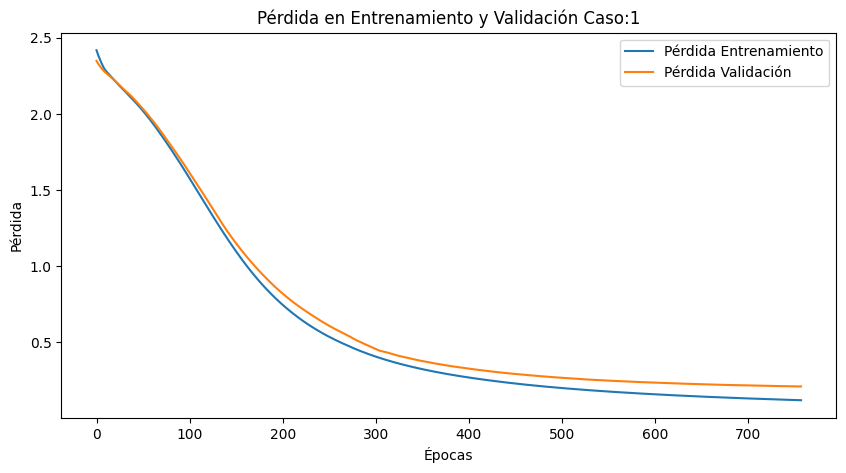

<Figure size 3000x3000 with 0 Axes>

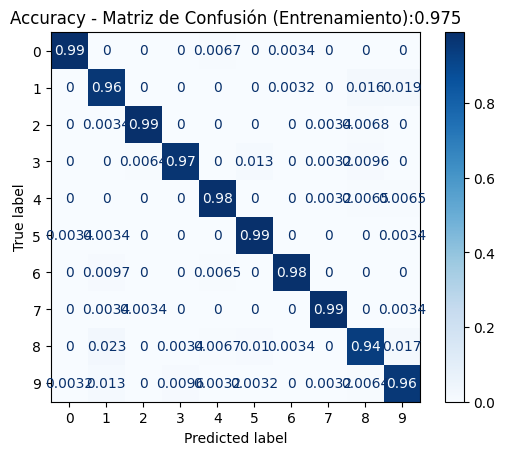

<Figure size 1500x1000 with 0 Axes>

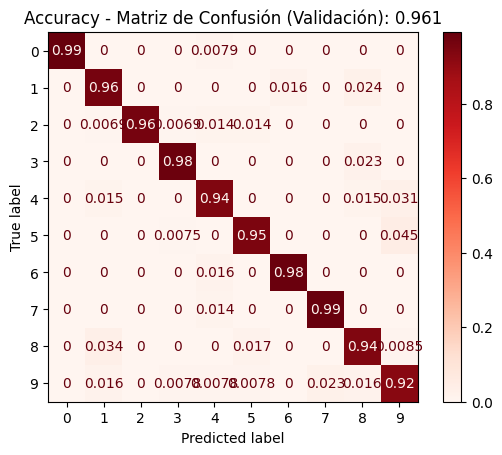

Entrenando modelo para el caso (2): 40 neuronas de capa oculta, usando función de activación ReLU y 1000 épocas como máximo


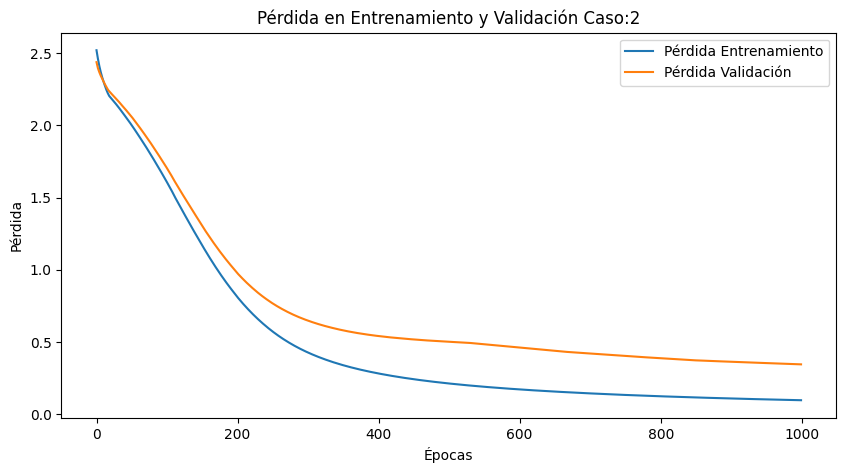

<Figure size 3000x3000 with 0 Axes>

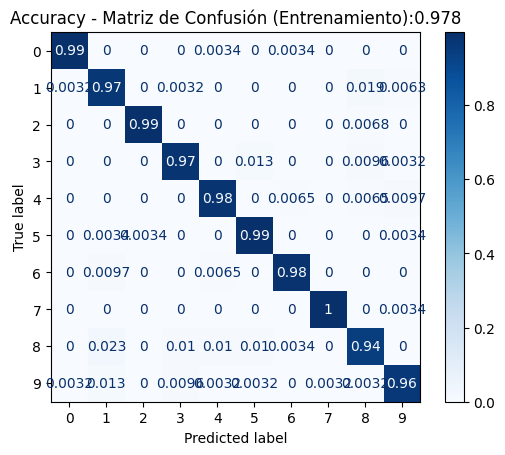

<Figure size 1500x1000 with 0 Axes>

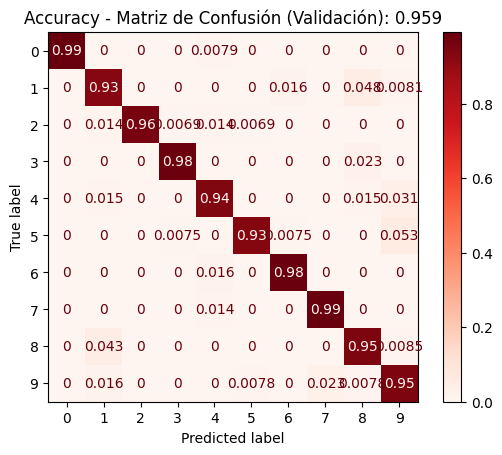

In [20]:
# Aplicar la normalización a ambos conjuntos (entrenamiento y validación)
X_train_normalized = scaler.transform(X_train)
X_val_normalized = scaler.transform(X_val)

# Función para entrenar una red neuronal
def train_neural_network(X_train, y_train, X_val, y_val, num_hidden_units, activation_fn, max_epochs):
    # Definir el modelo de la red neuronal
    model = nn.Sequential(
        nn.Linear(64, num_hidden_units),
        activation_fn,
        nn.Linear(num_hidden_units, 10),
        nn.LogSoftmax(dim=1)
    )

    # Función de pérdida y optimizador
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters())

    train_losses = []
    val_losses = []
    epochs = []
    best_val_loss = np.inf

    for epoch in range(max_epochs):
        optimizer.zero_grad()
        output = model(torch.Tensor(X_train))
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        # Calcular la pérdida en el conjunto de validación
        with torch.no_grad():
            val_output = model(torch.Tensor(X_val))
            val_loss = criterion(val_output, y_val)
            val_losses.append(val_loss.item())
            train_losses.append(loss.item())
            epochs.append(epoch)

            # Detener el entrenamiento si la pérdida en validación comienza a aumentar
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f'model_{num_hidden_units}_{activation_fn.__class__.__name__}.pt')
            else:
                break

    # Cargar el modelo con la mejor pérdida en validación
    model.load_state_dict(torch.load(f'model_{num_hidden_units}_{activation_fn.__class__.__name__}.pt'))
    return model, train_losses, val_losses, epochs

# Entrenar y evaluar modelos para los casos especificados
cases = [
    #(b) 40 neuronas en la capa oculta y función de activación ReLU, y 1000 épocas como máximo
    {"num_hidden_units": 40, "activation_fn": nn.ReLU(), "max_epochs": 1000},
    #(f) 2 capas ocultas con 40 y 40 neuronas cada una y función de activación ReLU, y 1000 épocas como máximo
    {"num_hidden_units": 40, "activation_fn": nn.ReLU(), "max_epochs": 1000}
]

for i, case in enumerate(cases):
    print(f"Entrenando modelo para el caso ({i+1}): {case['num_hidden_units']} neuronas de capa oculta, usando función de activación {case['activation_fn'].__class__.__name__} y 1000 épocas como máximo")

    model, train_losses, val_losses, epochs = train_neural_network(X_train_normalized, y_train, X_val_normalized, y_val, case["num_hidden_units"], case["activation_fn"], case["max_epochs"])

    # Gráficos de pérdida
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Pérdida Entrenamiento')
    plt.plot(epochs, val_losses, label='Pérdida Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.title(f"Pérdida en Entrenamiento y Validación Caso:{i+1}")
    plt.show()

    # Matriz de confusión y precisión en el conjunto de entrenamiento
    y_pred_train = model(torch.Tensor(X_train_normalized)).argmax(dim=1).numpy()
    cm_train = confusion_matrix(y_train.numpy(), y_pred_train, normalize='true')
    accuracy_train = accuracy_score(y_train.numpy(), y_pred_train)

    # Gráfico de la matriz de confusión en el conjunto de entrenamiento
    plt.figure(figsize=(30, 30))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=np.arange(10))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Accuracy - Matriz de Confusión (Entrenamiento):{accuracy_train:.3f}")
    plt.show()

    # Matriz de confusión y precisión en el conjunto de validación
    y_pred_val = model(torch.Tensor(X_val_normalized)).argmax(dim=1).numpy()
    cm_val = confusion_matrix(y_val.numpy(), y_pred_val, normalize='true')
    accuracy_val = accuracy_score(y_val.numpy(), y_pred_val)
    # Gráfico de la matriz de confusión en el conjunto de validación
    plt.figure(figsize=(15, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=np.arange(10))
    disp.plot(cmap=plt.cm.Reds)
    plt.title(f"Accuracy - Matriz de Confusión (Validación): {accuracy_val:.3f}")
    plt.show()
